# LegacyHalos Surface Brightness Profiles

This notebook demonstrates--using a handful of galaxies as examples--how we measure and model the surface brightness profiles of the central galaxies in our sample.  

We use Michele Cappellari's [mge_fit_sectors](http://purl.org/cappellari/software) software to measure the azimuthally averaged surface-brightness profiles and fit various parameteric models to the data to determine the sizes and integrated fluxes of the galaxies in our sample.

We fit the complete sample using the script legacyhalos.legacyhalos_sbprofiles and generate QAplots from the output using legacyhalos.qaplots_legacyhalos_sbprofiles.

### Installing mge_fit_sectors

To install mge_fit_sectors we downloaded the [2017-07-08 tarball] (give the link!), unpacked its contents to a new **/path/to/mge_2017_07_28/mge** directory and added the top-level directory to our PYTHONPATH:

```python
export PYTHONPATH=/path/to/mge_2017_07_28:$PYTHONPATH
```
We also had to change line 274 in **mge_fit_sectors** to
```python
  from mge.cap_mpfit import mpfit
```
in order for the minimization algorithm to be imported successfully.

### Imports, paths, and other preliminaries.

In [1]:
import os 
import numpy as np

from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt

In [2]:
import legacyhalos.io
from legacyhalos.qa import display_multiband, display_ellipsefit, display_ellipse_sbprofile
from legacyhalos.ellipse import ellipsefit_multiband
from legacyhalos.ellipse import mgefit_multiband

In [3]:
from photutils.isophote import (EllipseGeometry, Ellipse, EllipseSample,
                                Isophote, IsophoteList)

In [4]:
from mge.find_galaxy import find_galaxy
from mge.sectors_photometry import sectors_photometry
from mge.mge_fit_sectors import mge_fit_sectors as fit_sectors
from mge.mge_print_contours import mge_print_contours as print_contours

In [5]:
plt.style.use('seaborn-talk')
%matplotlib inline

In [6]:
pixscale = 0.262 # [arcsec/pix] - assume DECam
band = ('g', 'r', 'z')
refband = 'r'

### Read the sample

In [7]:
def read_sample():
    cols = ('ra', 'dec', 'bx', 'by', 'brickname', 'objid', 'type',
            'shapeexp_r', 'shapeexp_e1', 'shapeexp_e2',
            'shapedev_r', 'shapedev_e1', 'shapedev_e2')
    sample = legacyhalos.io.read_catalog(extname='LSPHOT', upenn=True, columns=cols)
        
    rm = legacyhalos.io.read_catalog(extname='REDMAPPER', upenn=True,
                                     columns=('mem_match_id', 'z', 'r_lambda'))
    sample.add_columns_from(rm)

    sample = sample[40]
    print('Read {} galaxies.'.format(len(sample)))
    return sample

In [8]:
sample = read_sample()

Read 1 galaxies.


In [9]:
objid, objdir = legacyhalos.io.get_objid(sample)
redshift = sample.z

### Reproduce ellipse fitting in legacyhalos.ellipse

In [10]:
data = legacyhalos.io.read_multiband(objid, objdir, band=band)
data.keys()

dict_keys(['g', 'g_mask', 'g_masked', 'r', 'r_mask', 'r_masked', 'z', 'z_mask', 'z_masked'])

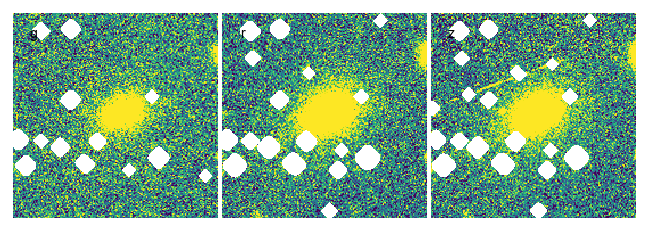

In [11]:
display_multiband(data)

#### Find the galaxy and get basic shape parameters in the reference r-band.

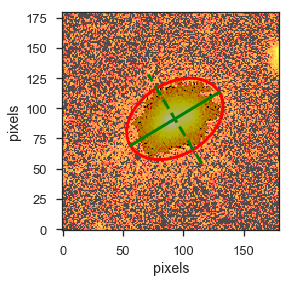

In [12]:
# Find the galaxy and perform MGE fitting
mgefit = mgefit_multiband(objid, objdir, data, band=band, refband=refband,
                          pixscale=pixscale, nofit=True, nowrite=True, 
                          debug=True)

The position angle in photutils is measured counter-clockwise from the x-axis (as documented [here](http://photutils.readthedocs.io/en/stable/api/photutils.isophote.EllipseGeometry.html#photutils.isophote.EllipseGeometry)) while *pa* in MGE is measured counter-clockwise from the y-axis.

In [13]:
geometry = EllipseGeometry(x0=mgefit['xmed'], y0=mgefit['ymed'], 
                           sma=mgefit['majoraxis'], eps=mgefit['eps'], 
                           pa=np.radians(mgefit['pa']-90))
print(geometry.x0, geometry.y0, geometry.sma, geometry.eps, np.degrees(geometry.pa))

91.2133233419 92.8658722298 39.0185211948 0.309868713704 30.9958171767


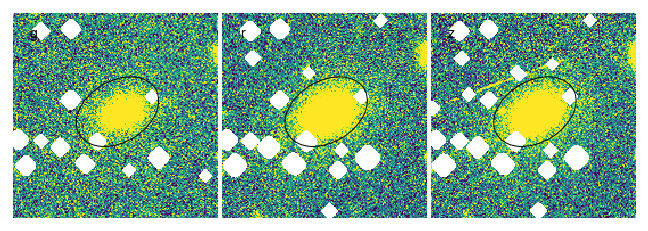

In [14]:
display_multiband(data, geometry=geometry)

In [15]:
ellipsefit = ellipsefit_multiband(objid, objdir, data, mgefit, 
                                  band=band, refband=refband, 
                                  nowrite=True)

In [16]:
ellipsefit['r'].to_table()

sma,intens,intens_err,ellipticity,ellipticity_err,pa,pa_err,grad_rerr,ndata,flag,niter,stop_code
,,,,,deg,deg,,,,,
float64,float64,float64,float64,float64,float64,float64,object,int64,int64,int64,int64
0.0,0.354346966909,0.0,0.0,0.0,0.0,0.0,None,1,0,0,0
0.507627989974,0.353566624817,0.000696489867979,0.133419354509,0.0101286595974,39.90750086447447,2.4883739760645627,None,13,0,1,5
0.558390788971,0.353160773492,0.000852928579942,0.133419354509,0.0274038808761,39.90750086447447,6.732527523081249,2.30941496376,13,0,1,5
0.614229867868,0.353829657171,0.00034088130325,0.168512490569,0.0268910257437,57.32835268839412,5.331820799178381,0.487538749982,13,0,10,0
0.675652854655,0.353092736539,0.000396145319253,0.151495476252,0.0237190278324,44.28869346256477,5.181388059685611,0.402677398693,13,0,10,0
0.743218140121,0.351791806076,0.000458654551113,0.153822689577,0.0232148978365,41.14449937287415,5.000392577278787,0.405349753286,13,0,10,0
0.817539954133,0.350004721455,0.000552310124305,0.147800973221,0.0216655133631,40.18716009846828,4.840758865560723,0.338240321765,13,0,10,0
0.899293949546,0.347087728569,0.000589952119662,0.104017210002,0.0203710407955,33.30427896732596,6.31993632131819,0.290571698064,13,0,10,0


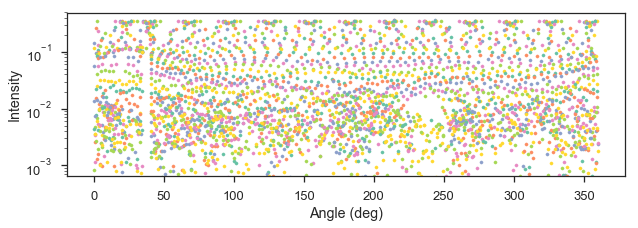

In [17]:
isos = ellipsefit['r']
fig, ax = plt.subplots(figsize=(10, 3))
for iso in isos:
    angles = ( np.degrees(iso.sample.values[0] + iso.sample.geometry.pa) ) % 360.
    ax.scatter(angles, iso.sample.values[2], s=10)
ax.set_xlabel('Angle (deg)')
ax.set_ylabel('Intensity')
ax.set_yscale('log')

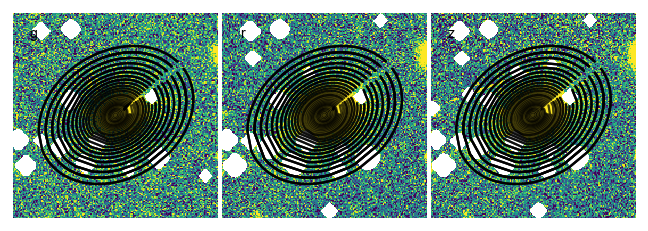

In [18]:
display_multiband(data, ellipsefit=ellipsefit)

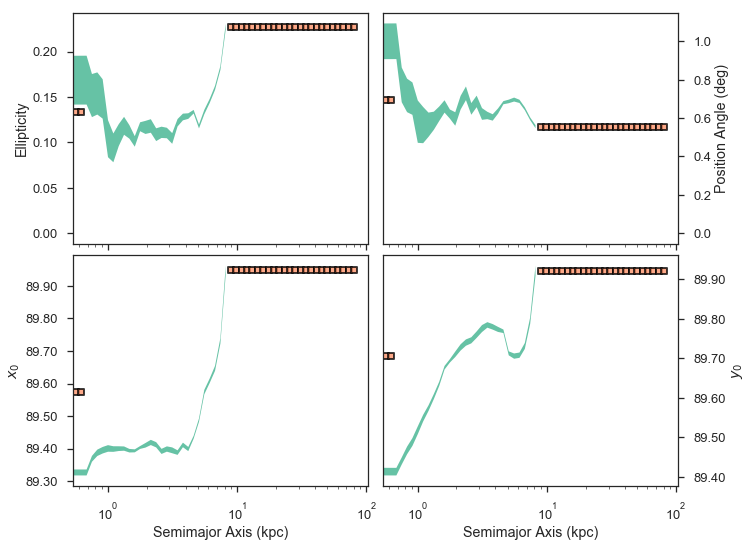

In [19]:
display_ellipsefit(ellipsefit, band=band, refband=refband, 
                   redshift=redshift, pixscale=pixscale,
                   xlog=True)

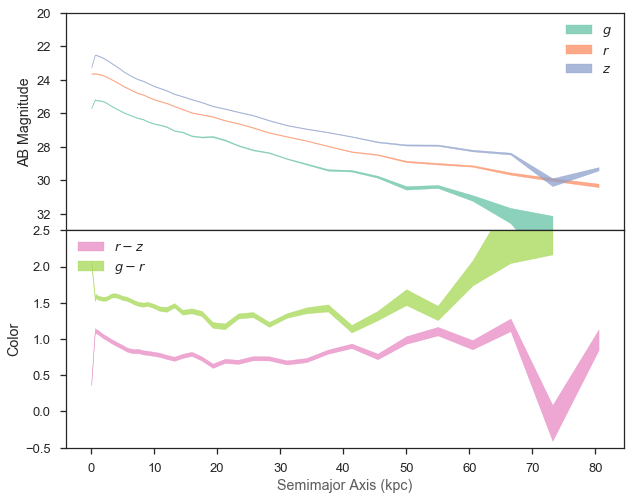

In [20]:
display_ellipse_sbprofile(ellipsefit, band=band, refband=refband, 
                          redshift=redshift, pixscale=pixscale)

In [21]:
stop

NameError: name 'stop' is not defined

In [ ]:
from matplotlib.ticker import FormatStrFormatter, ScalarFormatter
smascale = 1
filt = 'r'
good = (ellipsefit[filt].stop_code < 4)
bad = ~good
fig, ax1 = plt.subplots()
ax1.fill_between(ellipsefit[filt].sma[good] * smascale, 
                 ellipsefit[filt].eps[good]-ellipsefit[filt].ellip_err[good],
                 ellipsefit[filt].eps[good]+ellipsefit[filt].ellip_err[good])

#ax1.errorbar(ellipsefit[filt].sma[good] * smascale,
#             ellipsefit[filt].eps[good],
#             ellipsefit[filt].ellip_err[good], marker='s', linestyle='none',
#             capsize=10, capthick=2, 
#             markersize=10)#, color=color[filt])
ax1.scatter(ellipsefit[filt].sma[bad] * smascale,
             ellipsefit[filt].eps[bad], marker='s', s=40, edgecolor='k', lw=2, alpha=0.75)
ax1.set_xscale('log')
ax1.xaxis.set_major_formatter(ScalarFormatter())

In [ ]:
filt = 'r'
print(len(ellipsefit[filt]))
indx = np.ones(len(ellipsefit[filt]), dtype=bool)
print(len(indx))

In [ ]:
img = data['r_masked']

In [ ]:
ellipse = Ellipse(img, geometry, threshold=None)
iso = ellipse.fit_image(sma0=5, maxsma=None)

In [ ]:
help(Ellipse)

### Reproduce MGE fitting in legacyhalos.ellipse

In [ ]:
gal = parent[0]

In [ ]:
suffix = '{0:05d}'.format(gal['OBJID'])
imfile = os.path.join(coaddsdir, suffix, '{}-image-r.fits.fz'.format(suffix))
modelfile = os.path.join(coaddsdir, suffix, '{}-model-r.fits.fz'.format(suffix))
img, hdr = fits.getdata(imfile, ext=0, header=True)
model = fits.getdata(modelfile, ext=0)

In [ ]:
residimg = img - model

In [ ]:
ff = find_galaxy(residimg, plot=True)

In [ ]:
ss = sectors_photometry(residimg, ff.eps, ff.theta, ff.xpeak, ff.ypeak, badpixels=None,
                           n_sectors=19, mask=None, minlevel=0, plot=True)

In [ ]:
fig, ax = plt.subplots()
ax.scatter(np.log10(ss.radius*pixscale), 22.5-2.5*np.log10(ss.counts), s=10)
ax.set_ylim(32, 22)

In [ ]:
pp = fit_sectors(ss.radius, ss.angle, ss.counts, ff.eps,
                 ngauss=12, negative=False, sigmaPSF=0, normPSF=1, scale=pixscale,
                 rbounds=None, qbounds=None, linear=False, quiet=False,
                 outer_slope=4, bulge_disk=False, sol=0, plot=True)

In [ ]:
_ = print_contours(residimg, ff.pa, ff.xpeak, ff.ypeak, pp.sol, 
                   binning=2, normpsf=1, magrange=6, mask=None, 
                   scale=pixscale, sigmapsf=0)